# Kissa- ja koiraluokittelija v1

Tässä projektin vaiheessa rakennamme simppelin neuroverkon, joka luokittelee kissojen ja koirien kuvia. Tarkoituksena on, että tämä asiakirja toimii ensimmäisenä vaiheena luokittelijan rakentamisessa. [Seuraavassa vaiheessa](./tuned_model.ipynb) koitamme parantaa tuloksia esimerkiksi luomalla lisää koulutusdataa kenitekoisesti sekä kokeilemalla eri parametreja ja kerroksia neuroverkolla. Myös kierrosten (epoch) lisäämistä tullaan kokeilemaan. Tässä asiakirjassa on selitetty, mitä tullaan tekemään ja millä tavalla. Lopuksi arvioimme mallin toimintaa ja sitä mitä tulemme seuraavalla iteratiivisella kierroksella parantamaan.

## Kirjastojen tuominen

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

## Tuodaan kuvat

### Koulutusaineisto

Luodaan **ImageDataGenerator** neuroverkon kouluttamiseksi kissojen ja koirien kuvien tietojoukolle. Datageneraattori soveltaa kuviin erilaisia lisäyksiä lennossa lisätäkseen harjoitussarjan monimuotoisuutta ja parantaakseen mallin kykyä yleistää ennen näkemättömään dataan. ImageDataGenerator käyttää satunnaisesti jokaiselle batchille määritettyjä lisäyksiä, kuten leikkausmuunnoksia, zoomausta ja vaakasuuntaisia käännöksiä, jokaiseen erän yksittäiseen kuvaan. Tämän lennossa tapahtuvan lisäyksen tavoitteena on keinotekoisesti lisätä koulutussarjan monipuolisuutta keräämättä uusia kuvia. Tämä auttaa mallia yleistämään paremmin näkymättömään dataan, koska se oppii tunnistamaan esineitä erilaisissa olosuhteissa ja muunnelmissa. 

Koulutusdata haetaan kansiosta käyttämällä seuraavia parametreja:

- target_size=(64, 64): Muuttaa kuvien koon määritettyihin mittoihin (64x64 pikseliä).
- batch_size=32: Luo 32 näytteen erät harjoituksen aikana.
- class_mode='binary': Määrittää, että tämä on binääriluokitusongelma. Tunnisteet ovat binäärisiä (0 tai 1), jotka osoittavat, ovatko kuvat kissoja vai koiria.

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

training_set = train_datagen.flow_from_directory('./temp/archive/training_set',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 8005 images belonging to 2 classes.


### Testiaineisto

Astetaan myös testijoukolle ImageDataGenerator, joka käyttää normalisointia pikseliarvoihin. Generaattori on konfiguroitu tarjoamaan eriä normalisoituja testikuvia ja niitä vastaavia labeleita neuroverkon testausvaiheen aikana. Normalisoidut arvot tekevät siitä yhdenmukaisen harjoitussarjaan sovelletun esikäsittelyn kanssa.

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_set= test_datagen.flow_from_directory(
        './temp/archive/test_set',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 2023 images belonging to 2 classes.


#### Tutkitaan koulutus ja testisarjoja

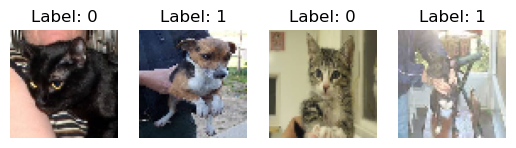

In [4]:
# Haetaan joukko kuvia ja labeleita harjoitussarjasta
batch_train = training_set.next()

# Poimitaan kuvat ja tarrat batchista
images, labels = batch_train

# Printataan muutama kuva
num_images_to_display = 4
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")

plt.show()

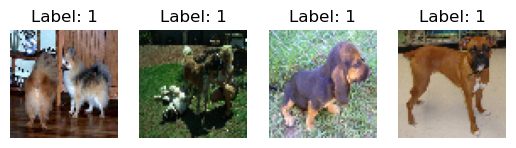

In [5]:
# Haetaan joukko kuvia ja labeleita testisarjasta
batch_test = test_set.next()

# Poimitaan kuvat ja tarrat batchista
images, labels = batch_test

# Printataan muutama kuva
num_images_to_display = 4
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")

plt.show()

## Konvoluutioneuroverkkomallin luominen

Tässä vaiheessa määritellään konvoluutioneuroverkko (CNN) käyttämällä Keras Sequential API:ta kuvien luokitukseen.

Malli koostuu kolmesta konvoluutiokerroksesta, joissa on max pooling, jota seuraa flattening ja dense kerros binääriluokittelua varten. ReLU-aktivointifunktiota käytetään konvoluutiokerroksissa ja sigmoidiaktivointifunktiota tuloskerroksessa binääriluokituksen todennäköisyyden ennustamiseen.

- **Sequential()** alustaa peräkkäisen mallin, jolloin voidaan lisätä tasoja peräkkäin.
- **Konvoluutiokerrokset maksimipoolauksella**: Kolme konvoluutiokerrosta lisätään malliin. Jokainen kerros käyttää ReLU (Recified Linear Unit) -aktivointia, ja sitä seuraa max-pooling-kerros. Ensimmäinen kerros määrittää myös input_shape=[64, 64, 3], mikä osoittaa, että tulokuvat ovat kooltaan 64x64 pikseliä ja kolme värikanavaa (RGB).
- **MaxPool2D** valitsee maksimiarvon jokaiselta syöttöominaisuuden alueelta. Tämä auttaa sieppaamaan tärkeitä ominaisuuksia ja pienentämään tietojen tilaulottuvuutta.
- **Flatten()** lisätään jotta saadaan malli tasoitettua 1D-muotoon. Tämä valmistelee tiedot täysin yhdistettyä kerrosta varten.
- **Dense()** lisää tiheän kerroksen, jossa on yksi yksikkö ja sigmoidiaktivointifunktio. Tätä kerrosta käytetään yleisesti binääriluokittelutehtävissä, joissa se tulostaa todennäköisyyden välillä 0 ja 1.

In [6]:
model = tf.keras.models.Sequential()

# Ensimmäinen kerros 'Conv2D'
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu',input_shape=[64,64,3]))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Toinen kerros
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Kolmas kerros
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Flatten kerros
model.add(tf.keras.layers.Flatten())

# Dense kerros
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

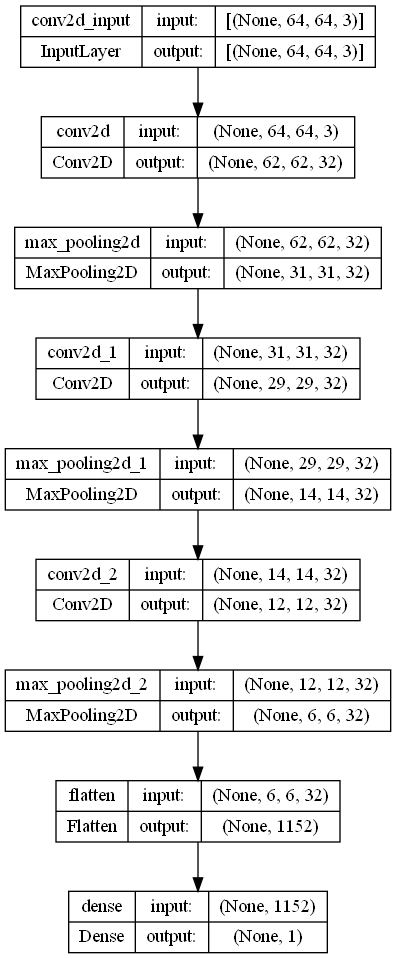

In [9]:
plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

## Mallin koulutus

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x=training_set, validation_data=test_set, epochs=5)

Epoch 1/5
251/251 [==============================] - 28s 107ms/step - loss: 0.6789 - accuracy: 0.5694 - val_loss: 0.6481 - val_accuracy: 0.6416
Epoch 2/5
251/251 [==============================] - 21s 85ms/step - loss: 0.5960 - accuracy: 0.6778 - val_loss: 0.5819 - val_accuracy: 0.6980
Epoch 3/5
251/251 [==============================] - 21s 85ms/step - loss: 0.5464 - accuracy: 0.7212 - val_loss: 0.5313 - val_accuracy: 0.7420
Epoch 4/5
251/251 [==============================] - 21s 85ms/step - loss: 0.5110 - accuracy: 0.7508 - val_loss: 0.5159 - val_accuracy: 0.7395
Epoch 5/5
251/251 [==============================] - 21s 85ms/step - loss: 0.4828 - accuracy: 0.7691 - val_loss: 0.5152 - val_accuracy: 0.7499
